# Variational AutoEncoder 구현
* 목적
  * Reparameterization 구현법 익히기

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import time

import tensorflow as tf
from tensorflow.keras import (models, layers, losses, 
                              optimizers, metrics)

import numpy as np
from scipy.stats import describe
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
tf.__version__

'2.0.0'

## 상수 정하기

In [3]:
LATENT_DIM = 2**8
ETA = 1e-3
EPOCHS = 50
BATCH_SIZE = 2**10

## 데이터 불러오기
* 이 예제에서는 MNIST 데이터 이용
* 아래 코드로 데이터를 불러옴
* shape을 이용해 데이터 레코드 개수와 어떤 모양인지 알 수 있음

In [4]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [5]:
print(X_train.shape, y_train.shape)

(60000, 28, 28) (60000,)


In [6]:
print(X_train.shape, X_test.shape)

(60000, 28, 28) (10000, 28, 28)


* 데이터 통계 확인

In [7]:
describe(np.array(X_train).flatten())

DescribeResult(nobs=47040000, minmax=(0, 255), mean=33.318421449829934, variance=6172.850613516908, skewness=2.151104099863995, kurtosis=2.9144234905841113)

In [8]:
describe(np.array(X_test).flatten())

DescribeResult(nobs=7840000, minmax=(0, 255), mean=33.791224489795916, variance=6268.279732209774, skewness=2.1285586190159993, kurtosis=2.8094527239057125)

* 데이터 \[0, 1\] 범위로 리스케일 해주기

In [9]:
X_train = np.expand_dims(np.squeeze(np.array(X_train, dtype=np.float32)), axis=-1)
X_test = np.expand_dims(np.squeeze(np.array(X_test, dtype=np.float32)), axis=-1)

X_train /= np.max(X_train)
X_test /= np.max(X_test)

X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [10]:
describe(np.array(X_train).flatten())

DescribeResult(nobs=47040000, minmax=(0.0, 1.0), mean=0.13066062, variance=0.09493039, skewness=2.151106357574463, kurtosis=2.9144181812310546)

In [11]:
describe(np.array(X_test).flatten())

DescribeResult(nobs=7840000, minmax=(0.0, 1.0), mean=0.13251467, variance=0.09639801, skewness=2.1285581588745117, kurtosis=2.809452489039299)

## 데이터 시각화
* 학습 데이터와 테스트 데이터에서 랜덤하게 몇 개 찍어보자.

In [12]:
def plot_samples(X):
    """
    args:
        숫자 이미지
    return:
        None
        임의의 그림을 9x9 subplots로 된 도화지에 그려줌
    """
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(5, 5))
    for row in range(3):
        for col in range(3):
            ax[row][col].imshow(np.squeeze(X[np.random.randint(X.shape[0])]))
            ax[row][col].axis('off')
    plt.show()

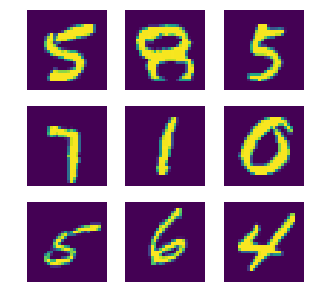

In [13]:
# 학습용 이미지
plot_samples(X_train)

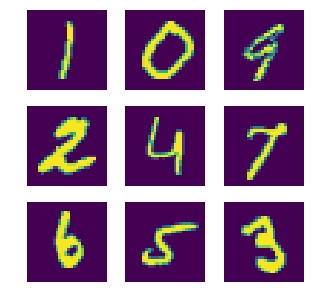

In [14]:
# 테스트용 이미지
plot_samples(X_test)

## 모델 만들기

In [15]:
class Encoder(models.Model):
    
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.cnn = models.Sequential([
            layers.Conv2D(filters=128, 
                          kernel_size=(3, 3),
                          strides=(1, 1),
                         ),
            layers.Activation(activation=tf.nn.leaky_relu),
            layers.Conv2D(filters=128, 
                          kernel_size=(3, 3),
                          strides=(1, 1),
                         ),
            layers.Activation(activation=tf.nn.leaky_relu),
            layers.Conv2D(filters=128, 
                          kernel_size=(3, 3),
                          strides=(1, 1),
                         ),
            layers.Activation(activation=tf.nn.leaky_relu),
        ])
        self.flat = layers.Flatten()
        self.mean = layers.Dense(latent_dim, activation=tf.nn.leaky_relu)
        self.logvar = layers.Dense(latent_dim, activation=tf.nn.leaky_relu)
        
    def call(self, inputs, training=False):
        x = self.cnn(inputs)
        shape = x.shape
        x = self.flat(x)
        mean = self.mean(x)
        logvar = self.logvar(x)
        z = self._reparameterization(mean, logvar)
        return z, mean, logvar, x.shape
    
    def _reparameterization(self, mean, logvar):
        z = tf.random.normal(mean.shape, mean=0., stddev=1.)
        z += mean
        return z

In [16]:
class Decoder(models.Model):
    
    def __init__(self, shape):
        super(Decoder, self).__init__()
        self.dense = layers.Dense(tf.reduce_prod(shape[1:]),
                                  activation=tf.nn.leaky_relu)
        self.reshape = layers.Reshape(shape[1:])
        self.transpose = models.Sequential([
            layers.Conv2DTranspose(filters=64,
                                  kernel_size=(9, 9),
                                  strides=(1, 1),
                                  ),
            layers.Activation(activation=tf.nn.leaky_relu),
            layers.Conv2DTranspose(filters=64,
                                  kernel_size=(9, 9),
                                  strides=(1, 1),
                                  ),
            layers.Activation(activation=tf.nn.leaky_relu),
            layers.Conv2DTranspose(filters=1,
                                  kernel_size=(12, 12),
                                  strides=(1, 1),
                                  ),
            layers.Activation(activation=tf.nn.sigmoid),
        ])
        
    def call(self, inputs, training=False):
        x = self.dense(inputs)
        x = self.reshape(x)
        x = tf.expand_dims(x, axis=1)
        x = tf.expand_dims(x, axis=1)
        outputs = self.transpose(x)
        return outputs

In [17]:
class VAE(models.Model):
    
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def call(self, inputs, training=False):
        z, mean, logvar, _ = self.encoder(inputs)
        outputs = decoder(z)
        
        return outputs, mean, logvar

## 로스 정하기

In [18]:
cce = losses.BinaryCrossentropy()

def model_loss(x, decoded, mean, logvar):
    """
    args:
        원본 이미지, 만들어진 이미지,
        이미지 분포의 mean, variance
    return:
        원본 이미지와 만들어진 이미지의 mse
        p(z)와 q(z|x) 의 KL-divergence
    """
    _loss = cce(x, decoded)
    kl_divergence = tf.reduce_mean(tf.pow(logvar, 2)) + tf.reduce_mean(tf.pow(mean, 2)) - tf.reduce_mean(tf.math.log(tf.pow(logvar, 2))) - 1
    
    return _loss,  kl_divergence

## 학습에 도움될 함수 만들기

In [19]:
opt = optimizers.Adam(learning_rate=ETA)
loss_mse = metrics.Mean()
loss_kl = metrics.Mean()

test_loss_mse = metrics.Mean()
test_loss_kl = metrics.Mean()

def train_step(inputs):
    x = inputs
    
    with tf.GradientTape() as t:
        decoded, mean, logvar = vae(x)
        _loss, _loss_kl = model_loss(x, decoded, mean, logvar)
        _loss_sum = _loss + _loss_kl
        
    grads = t.gradient(_loss_sum, vae.trainable_variables)
    opt.apply_gradients(zip(grads, vae.trainable_variables))
    
    loss_mse.update_state(_loss)
    loss_kl.update_state(_loss_kl)
    
def test_step(inputs):
    x = inputs
    
    decoded, mean, logvar = vae(x)
    _loss, _loss_kl = model_loss(x, decoded, mean, logvar)
    _loss_sum = _loss + _loss_kl

    test_loss_mse.update_state(_loss)
    test_loss_kl.update_state(_loss_kl)

## 모델 클래스 생성

In [20]:
encoder = Encoder(LATENT_DIM)
z, _, _, shape = encoder(np.ones((2, 28, 28, 1), dtype=np.float32))
decoder = Decoder(shape)
decoder(z)
vae = VAE(encoder, decoder)
pseudo = vae(np.ones((2, 28, 28, 1), dtype=np.float32))[0]

## 모델 학습

In [21]:
mse_loss_list, kl_loss_list = [], []

train_dataset = tf.data.Dataset\
    .from_tensor_slices(X_train[:X_train.shape[0]])\
    .shuffle(X_train.shape[0])\
    .batch(BATCH_SIZE)

for e in range(EPOCHS):
    start_time = time.time()
    
    for x in train_dataset:
        train_step(x)
        
    if (e+1)%10 == 0 or e == 0:
        print(f"{e+1}/{EPOCHS}, reconst loss = {loss_mse.result():.8f}, kl loss = {loss_kl.result():.8f}, {time.time() - start_time:.2f} sec/epoch")
        
    mse_loss_list.append(loss_mse.result())
    kl_loss_list.append(loss_kl.result())
    
    loss_mse.reset_states()
    loss_kl.reset_states()

1/50, reconst loss = 0.31605735, kl loss = 0.98638231, 32.34 sec/epoch
10/50, reconst loss = 0.20991834, kl loss = 0.03149533, 30.69 sec/epoch
20/50, reconst loss = 0.20387587, kl loss = 0.03474417, 30.79 sec/epoch
30/50, reconst loss = 0.20073628, kl loss = 0.03602441, 30.84 sec/epoch
40/50, reconst loss = 0.19933945, kl loss = 0.03694614, 30.83 sec/epoch
50/50, reconst loss = 0.19754967, kl loss = 0.03770971, 30.80 sec/epoch


## 학습 로스 시각화

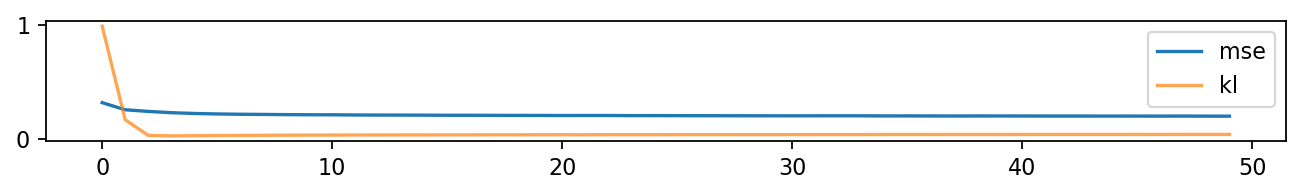

In [22]:
plt.figure(figsize=(10, 1), dpi=160)
plt.plot(mse_loss_list, label='mse')
plt.plot(kl_loss_list, label='kl', alpha=.7)
plt.legend()
plt.show()

## 모델 성능 평가

In [23]:
test_dataset = tf.data.Dataset\
    .from_tensor_slices(X_test)\
    .batch(BATCH_SIZE)

start_time = time.time()

for x in test_dataset:
    test_step(x)

print(f"reconst loss = {test_loss_mse.result():.8f}, kl loss = {test_loss_kl.result():.8f}, {time.time() - start_time:.2f} sec/epoch")

reconst loss = 0.19655684, kl loss = 0.03799983, 2.53 sec/epoch


In [26]:
def get_decoded(X):
    decoded = np.zeros(X.shape)

    for s in range(0, X.shape[0], BATCH_SIZE):
        e = min(X.shape[0], s+BATCH_SIZE)
        decoded[s:e], _, _ = vae(X[s:e])

    return decoded

decoded = get_decoded(X_test)

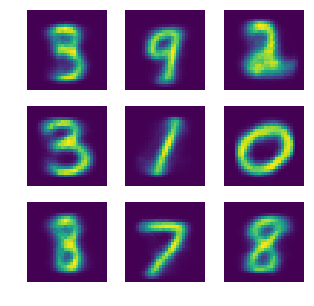

In [27]:
plot_samples(decoded)